<a href="https://colab.research.google.com/github/DajanaIsaku/PPPO_DetekcijaObjekata/blob/main/Copy_of_DetekcijaObjekata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Projektni zadatak iz predmeta principi prezentacije i prepoznavanja oblika**

Student: Dajana Isaku IT 27/2020

Tema projektnog zadatka: Detekcija objekata (broda)


In [ ]:
from google.colab import drive


In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gdown


In [ ]:
import gdown


In [ ]:
import os
import sys
import random
import math
import warnings
import numpy as np
import cv2



In [ ]:
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd
import glob
import numpy as np
import pandas as pd
from skimage.io import imread

In [ ]:
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable()

In [ ]:

!git clone https://github.com/maxw1489/Mask_RCNN.git
os.chdir('Mask_RCNN')

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [ ]:
sys.path.append(os.path.join('Mask_RCNN'))

In [ ]:
from mrcnn.config import Config


In [ ]:
from mrcnn import utils


In [ ]:
import mrcnn.model as modellib


In [ ]:
from mrcnn import visualize


In [ ]:
from mrcnn.model import log


In [ ]:

!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Dec  6  2021 mask_rcnn_coco.h5


In [ ]:

data_dir = '/content/drive/MyDrive/Ships_Detection'
main_dir = '/content/drive/MyDrive/'


In [ ]:
train_dir = os.path.join(data_dir, 'train_v2')
test_dir = os.path.join(data_dir, 'test_v2')

In [ ]:

import os

train_images = os.listdir(train_dir)
num_train_images = len(train_images)

test_images = os.listdir(test_dir)
num_test_images = len(test_images)



In [ ]:
# slike za obuku
print(num_train_images)

# slike za testiranje
print(num_test_images)

33533
6882


In [ ]:

import pandas as pd
import os

In [ ]:
csv_file1 = os.path.join('/content/drive/MyDrive/Ships_Detection/', 'sample_submission_v2.csv')
csv_file2 = os.path.join('/content/drive/MyDrive/Ships_Detection/', 'train_ship_segmentations_v2.csv')


In [ ]:
df1 = pd.read_csv(csv_file1)
df2 = pd.read_csv(csv_file2)

# DataFrame

print("\nsample_submission_v2.csv:")
print(df1)

print("\ntrain_ship_segmentations_v2.csv:")
print(df2)


sample_submission_v2.csv:
             ImageId EncodedPixels
0      00002bd58.jpg           1 2
1      00015efb6.jpg           1 2
2      00023d5fc.jpg           1 2
3      000367c13.jpg           1 2
4      0008ca6e9.jpg           1 2
...              ...           ...
15601  ffdb3cda6.jpg           1 2
15602  ffe3857eb.jpg           1 2
15603  ffeb765e8.jpg           1 2
15604  ffeba1475.jpg           1 2
15605  fff0fd44f.jpg           1 2

[15606 rows x 2 columns]

train_ship_segmentations_v2.csv:
             ImageId                                      EncodedPixels
0      000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
1      000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
2      000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
3      000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
4      000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...              ...                                         

In [ ]:

import pandas as pd

# Učitavanje CSV fajla sa podacima o treningu
train_csv = '/content/drive/MyDrive/Ships_Detection/train_ship_segmentations_v2.csv'
df_train = pd.read_csv(train_csv)





In [ ]:
# Raspodela klasa
class_counts = df_train['EncodedPixels'].notnull().value_counts()

print("Raspodela klasa:")
print(class_counts)

Raspodela klasa:
False    23396
True     12639
Name: EncodedPixels, dtype: int64


In [ ]:
from PIL import Image


In [ ]:

from sklearn.model_selection import train_test_split
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg',
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

def filter_file_names(directory, exclude_list):
    file_names = []
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.is_file() and entry.name not in exclude_list:
                file_names.append(entry.name)
    return file_names

train_names = filter_file_names(train_dir, exclude_list)
test_names = filter_file_names(test_dir, exclude_list)



In [ ]:
debug = False


In [ ]:
df = pd.DataFrame({'File Name': train_names})
df.to_csv('/content/drive/MyDrive/Ships_Detection/train_names.csv', index=False)




In [ ]:
df = pd.DataFrame({'File Name': test_names})
df.to_csv('/content/drive/MyDrive/Ships_Detection/test_names.csv', index=False)

In [ ]:
print(train_names)

print(len(train_names), len(test_names))

['522ddf3dc.jpg', '52394a336.jpg', '523602e05.jpg', '522c8b060.jpg', '523be8565.jpg', '5230b6a28.jpg', '52317a68a.jpg', '523af81fa.jpg', '522b2a171.jpg', '522f3223b.jpg', '52385dcbc.jpg', '52372a950.jpg', '5240bd1a2.jpg', '5247dd6d3.jpg', '5241872da.jpg', '5243a5336.jpg', '524f26dc6.jpg', '5240bf0bd.jpg', '525136bab.jpg', '524342768.jpg', '524a5f12f.jpg', '5251dd701.jpg', '5248ee313.jpg', '5240e8463.jpg', '52467bd6c.jpg', '5242aacf6.jpg', '524d74f75.jpg', '524b30fcc.jpg', '52563e1f9.jpg', '524bc1b50.jpg', '5248a7ac7.jpg', '524821b75.jpg', '524729ebf.jpg', '524e1c5e0.jpg', '524a6f733.jpg', '524cffc50.jpg', '52531b6c9.jpg', '524fe24d6.jpg', '52554c148.jpg', '5241789ba.jpg', '52429d8f4.jpg', '525762217.jpg', '52448d074.jpg', '524736a65.jpg', '5251dca7f.jpg', '5251a816f.jpg', '52554d6ee.jpg', '524191681.jpg', '524a741da.jpg', '524887fdd.jpg', '524b35fa8.jpg', '5242b0f4c.jpg', '5246fb5a0.jpg', '525413014.jpg', '524aa9823.jpg', '525310b8a.jpg', '524f93e3e.jpg', '524e30744.jpg', '524d38656.jp

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Ships_Detection/train_names.csv')

train_names1 = df['File Name']


df = pd.read_csv('/content/drive/MyDrive/Ships_Detection/test_names.csv')

test_names1 = df['File Name']


In [ ]:
image_folder = '/content/drive/MyDrive/Ships_Detection/train_v2'


csv_file = '/content/drive/MyDrive/Ships_Detection/train_ship_segmentations_v2.csv'

image_names = [os.path.splitext(filename)[0] + '.jpg' for filename in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, filename))]

data = pd.read_csv(csv_file)

filtered_data = data[data['ImageId'].isin(image_names)]

filtered_data.to_csv('/content/drive/MyDrive/Ships_Detection/train_ship_segmentations_v3.csv',index=False)

In [ ]:
rle = '/content/drive/MyDrive/Ships_Detection/train_ship_segmentations_v3.csv'
annotations = pd.read_csv(rle)
annotations.shape

(36035, 2)

In [ ]:
im_names, image_annotations = train_names1, annotations


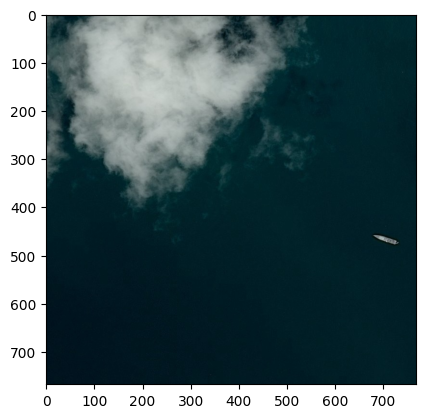

In [ ]:
ds = imread(os.path.join(train_dir, im_names[0]))
_ = plt.imshow(ds)


In [ ]:
ORIG_SIZE = 768


In [ ]:

class ModelConfig(Config):

    NAME = 'Initial'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    BACKBONE = 'resnet50'

    NUM_CLASSES = 2

    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64)  #different window sizes in RPN achors
    TRAIN_ROIS_PER_IMAGE = 64
    MAX_GT_INSTANCES = 2
    DETECTION_MAX_INSTANCES = 15
    DETECTION_MIN_CONFIDENCE = 0.85
    DETECTION_NMS_THRESHOLD = 0.0
    RUN_EAGERLY = False

    STEPS_PER_EPOCH = 15 if debug else 5
    VALIDATION_STEPS = 10 if debug else 3

    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.2
    }

config = ModelConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        15
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 30.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.2}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [ ]:

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [ ]:
class LoadDataset(utils.Dataset):
    """Dataset class for training our dataset.
    """

    def __init__(self, im_names, image_annotations, orig_height, orig_width):
        super().__init__(self)

        self.add_class('ship', 1, 'Ship')

        for i, fp in enumerate(im_names):
            annotations = image_annotations.query('ImageId=="' + fp + '"')['EncodedPixels']
            self.add_image('ship', image_id=i, path=os.path.join(train_dir, fp),
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
#         print(image_id, annotations)
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask[:, :, i] = rle_decode(a)
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [ ]:
from sklearn.model_selection import train_test_split
train_names1 = annotations[annotations.EncodedPixels.notnull()].ImageId.unique().tolist()  ## override with ships

test_size = config.VALIDATION_STEPS * config.IMAGES_PER_GPU
im_names_train, im_names_val = train_test_split(train_names1, test_size=test_size, random_state=42)

if debug:
    im_names_train = im_names_train[:100]
    im_names_val = im_names_val[:100]
    test_names1 = test_names1[:100]

print(len(im_names_train), len(im_names_val), len(test_names1))

6538 24 6882


In [ ]:
%%time
dataset_train = LoadDataset(im_names_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

CPU times: user 21.4 s, sys: 312 ms, total: 21.7 s
Wall time: 22 s


In [ ]:
%%time
dataset_val = LoadDataset(im_names_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

CPU times: user 126 ms, sys: 1.64 ms, total: 128 ms
Wall time: 380 ms


In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=main_dir)


In [ ]:
LEARNING_RATE = 0.003

import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads')

history = model.keras_model.history.history


Starting at epoch 0. LR=0.006

Checkpoint Path: /content/drive/MyDrive/initial20240121T1801/mask_rcnn_initial_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=2,
            layers='all')

new_history = model.keras_model.history.history


Starting at epoch 2. LR=0.003

Checkpoint Path: /content/drive/MyDrive/initial20240121T1801/mask_rcnn_initial_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2

In [ ]:
history

{'loss': [271.5439758300781, 241.9595184326172],
 'rpn_class_loss': [250.712158203125, 229.7461395263672],
 'rpn_bbox_loss': [6.281377792358398, 5.814583778381348],
 'mrcnn_class_loss': [7.244105339050293, 1.6651203632354736],
 'mrcnn_bbox_loss': [6.733105659484863, 4.333428859710693],
 'mrcnn_mask_loss': [0.5732375383377075, 0.4002740979194641],
 'val_loss': [508.7471923828125, 139.67332458496094],
 'val_rpn_class_loss': [499.890380859375, 133.5048065185547],
 'val_rpn_bbox_loss': [4.156755447387695, 5.35447359085083],
 'val_mrcnn_class_loss': [5.193716788198799e-06, 0.10891785472631454],
 'val_mrcnn_bbox_loss': [4.43646764755249, 0.44709548354148865],
 'val_mrcnn_mask_loss': [0.263589471578598, 0.25802627205848694]}

In [ ]:
new_history

{}

In [ ]:
import pickle


In [ ]:
with open('/content/drive/MyDrive/Ships_Detection/history.pkl', 'wb') as file:
    pickle.dump(history, file)

In [ ]:
epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history, index=epochs)

,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss
1,271.543976,250.712158,6.281378,7.244105,6.733106,0.573238,508.747192,499.890381,4.156755,0.000005,4.436468,0.263589
2,241.959518,229.746140,5.814584,1.665120,4.333429,0.400274,139.673325,133.504807,5.354474,0.108918,0.447095,0.258026


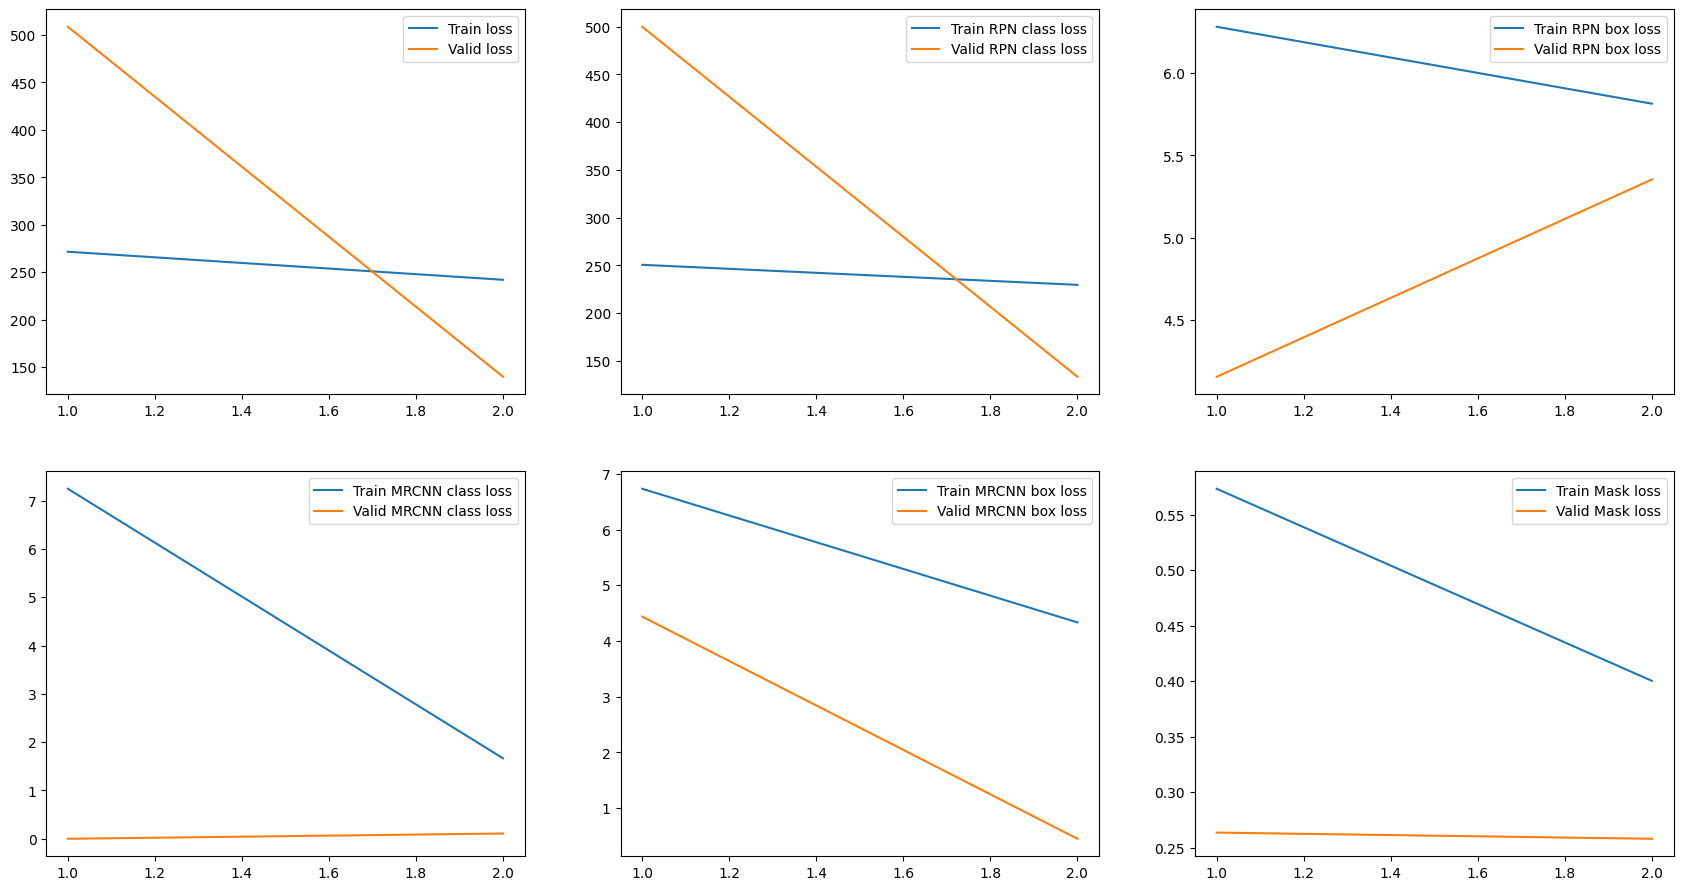

In [ ]:
plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class loss")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class loss")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class loss")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class loss")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()

In [ ]:
best_epoch = np.argmin(history["val_loss"])
score = history["val_loss"][best_epoch]
print(f'Best Epoch:{best_epoch+1} val_loss:{score}')

Best Epoch:2 val_loss:139.67332458496094


In [ ]:
model_path ="/content/drive/MyDrive/initial20240121T1801/mask_rcnn_initial_0001.h5"


In [ ]:
class InferenceConfig(ModelConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference',
                          config=inference_config,
                          model_dir=main_dir)

print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/MyDrive/initial20240121T1801/mask_rcnn_initial_0001.h5
Re-starting from epoch 1


In [ ]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

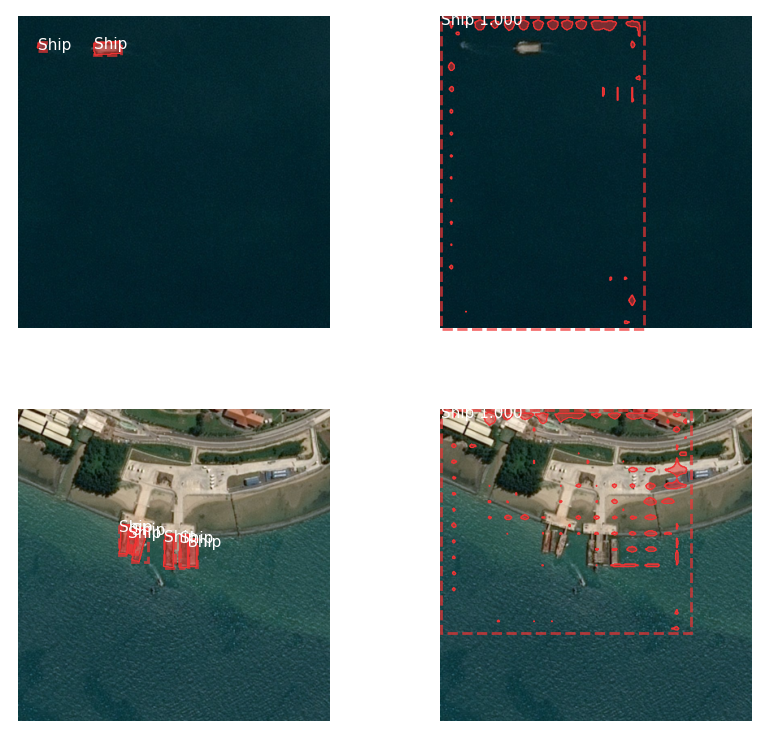

In [ ]:
dataset = dataset_val
fig = plt.figure(figsize=(10, 40))

for i in range(4,6,1):

    image_id = random.choice(dataset.image_ids)

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)

    plt.subplot(8, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])

    plt.subplot(8, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                                dataset.class_names, r['scores'],
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [ ]:
import numpy as np

# Define a function to calculate AP, mAP, IoU, and Kaggle F2 score
def calculate_ap_map_iou_f2(model, dataset, inference_config):
    APs = []
    IoUs = []
    F2s = []
    gt_bbox_list = []
    gt_class_id_list = []
    gt_mask_list = []
    pred_bbox_list = []
    pred_class_id_list = []
    pred_score_list = []

    # Loop through the dataset
    for image_id in dataset.image_ids:
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
            modellib.load_image_gt(dataset, inference_config, image_id, use_mini_mask=False)

        # Append ground truth annotations to lists
        gt_bbox_list.append(gt_bbox)
        gt_class_id_list.append(gt_class_id)
        gt_mask_list.append(gt_mask)

        # Run inference on the image
        results = model.detect([original_image])
        r = results[0]

        # Append predicted results to lists
        pred_bbox = r['rois']
        pred_class_ids = r['class_ids']
        pred_scores = r['scores']
        pred_masks = r['masks']
        pred_bbox_list.append(pred_bbox)
        pred_class_id_list.append(pred_class_ids)
        pred_score_list.append(pred_scores)

        # Compute AP and IoU for the image
        AP, _, _, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, pred_bbox, pred_class_ids, pred_scores, pred_masks, iou_threshold=0.5)  # Use IoU threshold of 0.5 for competition evaluation
        APs.append(AP)

        # Calculate IoU
        valid_overlaps = overlaps[~np.isnan(overlaps)]  # Exclude NaN IoU values
        if len(valid_overlaps) > 0:
            IoU = np.mean(valid_overlaps)
            IoUs.append(IoU)

        # Calculate Kaggle F2 score
        TP = len(overlaps) - np.isnan(overlaps).sum()  # True Positives (excluding NaN IoU values)
        FN = len(gt_bbox) - TP  # False Negatives
        FP = len(pred_bbox) - TP  # False Positives
        beta = 2  # F2 score weight for recall (increase weight of recall)
        F2 = ((1 + beta*2) * TP) / ((1 + beta*2) * TP + beta*2 * FN + FP)  # Modified Kaggle F2 score formula
        F2s.append(F2)

    # Calculate mean Average Precision (mAP), mean IoU (excluding NaN values), and mean Kaggle F2 score
    mAP = np.mean(APs)
    mean_IoU = np.nanmean(IoUs) if len(IoUs) > 0 else np.nan
    mean_F2 = np.mean(F2s)

    return APs, mAP, IoUs, mean_IoU, F2s, mean_F2

# Call the function to calculate AP, mAP, IoU, and Kaggle F2 score
APs, mAP, IoUs, mean_IoU, F2s, mean_F2 = calculate_ap_map_iou_f2(model, dataset_val, inference_config)

# Print the results
print("Average Precision (AP) per class:")
for i, AP in enumerate(APs):
    print(f"Class {i}: AP = {AP}")

print("Mean Average Precision (mAP):", mAP)

print("Intersection over Union (IoU) per image:")
for i, IoU in enumerate(IoUs):
    print(f"Image {i}: IoU = {IoU}")

print("Mean IoU (excluding NaN values):", mean_IoU)

print("Kaggle F2 score per image:")
for i, F2 in enumerate(F2s):
    print(f"Image {i}: F2 score = {F2}")

print("Mean Kaggle F2 score:", mean_F2)

Average Precision (AP) per class:
Class 0: AP = 0.0
Class 1: AP = 0.0
Class 2: AP = 0.0
Class 3: AP = 0.0
Class 4: AP = 0.0
Class 5: AP = 0.0
Class 6: AP = 0.0
Class 7: AP = 0.0
Class 8: AP = 0.0
Class 9: AP = 0.0
Class 10: AP = 0.0
Class 11: AP = 0.0
Class 12: AP = 0.0
Class 13: AP = 0.0
Class 14: AP = 0.0
Class 15: AP = 0.0
Class 16: AP = 0.0
Class 17: AP = 0.0
Class 18: AP = 0.0
Class 19: AP = 0.0
Class 20: AP = 0.0
Class 21: AP = 0.0
Class 22: AP = 0.0
Class 23: AP = 0.0
Mean Average Precision (mAP): 0.0
Intersection over Union (IoU) per image:
Image 0: IoU = 0.021936459466814995
Image 1: IoU = 0.0
Image 2: IoU = 0.0010278214467689395
Image 3: IoU = 0.0
Image 4: IoU = 0.0
Image 5: IoU = 0.0
Image 6: IoU = 0.0
Image 7: IoU = 0.0021648965775966644
Image 8: IoU = 0.002107764594256878
Image 9: IoU = 0.0
Image 10: IoU = 0.0
Image 11: IoU = 0.0
Image 12: IoU = 0.0
Image 13: IoU = 0.0
Image 14: IoU = 0.0
Image 15: IoU = 0.0
Image 16: IoU = 0.002352941082790494
Image 17: IoU = 0.0072398190